# DSCI 617 – Project 03
## Forest Cover Prediction
**Felix Asare**


## Part A: Set up Environment

Creating libraries for the project

In [0]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
 
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, expr
 
from pyspark.ml.feature import VectorAssembler, OneHotEncoder, StringIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier
from pyspark.ml import Pipeline
 
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
 
spark = SparkSession.builder.getOrCreate()

## Part B: Load and Explore the Data

Using DDL string to create schema for the DataFrame

In [0]:
# Creating Schema
fc = (
    spark.read
    .option("header", True)
    .option('delimiter', '\t')
    .schema(
      'Elevation INT, Aspect INT, Slope INT, Horizontal_Distance_To_Hydrology INT, Vertical_Distance_To_Hydrology INT, Horizontal_Distance_To_Roadways INT, Hillshade_9am INT, Hillshade_Noon INT, Hillshade_3pm INT, Horizontal_Distance_To_Fire_Points INT, Wilderness_Area STRING, Soil_Type INT, Cover_Type INT'
    )
    .csv('/FileStore/tables/forest_cover.txt')
)

fc.printSchema()

root
 |-- Elevation: integer (nullable = true)
 |-- Aspect: integer (nullable = true)
 |-- Slope: integer (nullable = true)
 |-- Horizontal_Distance_To_Hydrology: integer (nullable = true)
 |-- Vertical_Distance_To_Hydrology: integer (nullable = true)
 |-- Horizontal_Distance_To_Roadways: integer (nullable = true)
 |-- Hillshade_9am: integer (nullable = true)
 |-- Hillshade_Noon: integer (nullable = true)
 |-- Hillshade_3pm: integer (nullable = true)
 |-- Horizontal_Distance_To_Fire_Points: integer (nullable = true)
 |-- Wilderness_Area: string (nullable = true)
 |-- Soil_Type: integer (nullable = true)
 |-- Cover_Type: integer (nullable = true)



Viewing dataframe 3 rows

In [0]:
column_list = fc.columns

# Select the first 6 columns and display the first 3 rows
first_six_columns = fc.select(column_list[:6])
print("First 6 columns:")
first_six_columns.show(3)

# Select all remaining columns and display the first 3 rows
remaining_columns = fc.select(column_list[6:])
print("Remaining columns:")
remaining_columns.show(3)

First 6 columns:
+---------+------+-----+--------------------------------+------------------------------+-------------------------------+
|Elevation|Aspect|Slope|Horizontal_Distance_To_Hydrology|Vertical_Distance_To_Hydrology|Horizontal_Distance_To_Roadways|
+---------+------+-----+--------------------------------+------------------------------+-------------------------------+
|     2596|    51|    3|                             258|                             0|                            510|
|     2590|    56|    2|                             212|                            -6|                            390|
|     2804|   139|    9|                             268|                            65|                           3180|
+---------+------+-----+--------------------------------+------------------------------+-------------------------------+
only showing top 3 rows

Remaining columns:
+-------------+--------------+-------------+----------------------------------+-------------

Determining the number of Observation

In [0]:
# Count Observation
N = fc.count()
print(N)

15120


Checking proportion of Cover_type

In [0]:
#Proportion of observation
fc.select('Cover_Type').groupBy('Cover_Type')\
    .agg(
        expr('count(*) as count'),
        expr(f'ROUND(COUNT(*)/{N}, 4) as prop')
    ).show()

+----------+-----+------+
|Cover_Type|count|  prop|
+----------+-----+------+
|         1| 2160|0.1429|
|         6| 2160|0.1429|
|         3| 2160|0.1429|
|         5| 2160|0.1429|
|         4| 2160|0.1429|
|         7| 2160|0.1429|
|         2| 2160|0.1429|
+----------+-----+------+



## Part C: Preprocessing and Splitting the Data

Processing data of the dataframe

In [0]:
# Seperating Numeric and Categorical Columns
num_features = [
    'Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
    'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
    'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 
    'Horizontal_Distance_To_Fire_Points'
]
cat_features = ['Wilderness_Area', 'Soil_Type']

ix_features = [c + '_ix' for c in cat_features]
vec_features = [c + '_vec' for c in cat_features]


feature_indexer = StringIndexer(inputCols=cat_features, outputCols=ix_features)
encoder = OneHotEncoder(inputCols=ix_features, outputCols=vec_features, dropLast=False)

assembler_lr = VectorAssembler(inputCols=num_features + vec_features, outputCol='features_lr')
assembler_dt = VectorAssembler(inputCols=num_features + vec_features, outputCol='features_dt')


Creating pipeline for the processed data

In [0]:
# Create pipeline
pipeline = Pipeline(stages=[feature_indexer, encoder, assembler_lr, assembler_dt]).fit(fc)
fc_proc = pipeline.transform(fc)
fc_proc.persist()

# Displayng the first 5 rows of features_dt and Cover_Type
fc_proc.select(['features_dt', 'Cover_Type']).show(5, truncate=False)

+--------------------------------------------------------------------------------------------------------+----------+
|features_dt                                                                                             |Cover_Type|
+--------------------------------------------------------------------------------------------------------+----------+
|(52,[0,1,2,3,5,6,7,8,9,12,15],[2596.0,51.0,3.0,258.0,510.0,221.0,232.0,148.0,6279.0,1.0,1.0])           |5         |
|(52,[0,1,2,3,4,5,6,7,8,9,12,15],[2590.0,56.0,2.0,212.0,-6.0,390.0,220.0,235.0,151.0,6225.0,1.0,1.0])    |5         |
|(52,[0,1,2,3,4,5,6,7,8,9,12,34],[2804.0,139.0,9.0,268.0,65.0,3180.0,234.0,238.0,135.0,6121.0,1.0,1.0])  |2         |
|(52,[0,1,2,3,4,5,6,7,8,9,12,20],[2785.0,155.0,18.0,242.0,118.0,3090.0,238.0,238.0,122.0,6211.0,1.0,1.0])|2         |
|(52,[0,1,2,3,4,5,6,7,8,9,12,15],[2595.0,45.0,2.0,153.0,-1.0,391.0,220.0,234.0,150.0,6172.0,1.0,1.0])    |5         |
+-------------------------------------------------------

Splitting Dataset into Training and Testing

In [0]:
# Split Dataset
splits = fc_proc.randomSplit([0.8, 0.2], seed=1) 
train = splits[0]
test = splits[1]

train.persist()

# Displaying the number of rows for train and test
print("Training Observation:", train.count())
print("Testing Observation: ", test.count())

Training Observation: 12118
Testing Observation:  3002


## Part D: Hyperparameter for Logistic Regression

Creating an accuracy evaluator to be used when performing hyperparameter tuning.

In [0]:
# Accuracy evaluator
accuracy_eval = MulticlassClassificationEvaluator(
    predictionCol='prediction', labelCol='Cover_Type', metricName='accuracy')

Creating Logistic Regression model and Cross validation

In [0]:
# Create a Logistic Regression class
logreg = LogisticRegression(featuresCol='features_lr', labelCol='Cover_Type')

# Create hyperparameters
paramGrid = (
    ParamGridBuilder()
        .addGrid(logreg.regParam, [0.00001, 0.0001, 0.001, 0.01, 0.1])
        .addGrid(logreg.elasticNetParam, [0, 0.5, 1])
).build()

# Creating crossvalidator
cv = CrossValidator(estimator=logreg, estimatorParamMaps=paramGrid, evaluator=accuracy_eval, numFolds=5, seed=1)

# Fitting the model
logreg_model = cv.fit(train)

Retriving optimal model

In [0]:
# Optimal model found by grid search
lr_model = logreg_model.bestModel

# Identify the optimal hyperparameters
opt_regParam = lr_model.getRegParam()
opt_enetParam = lr_model.getElasticNetParam()

# Printing the optimal hyperparameters
print('Max CV Score:  ', round(max(logreg_model.avgMetrics),4))
print('Optimal Lambda:', opt_regParam)
print('Optimal Alpha: ', opt_enetParam)

Max CV Score:   0.7048
Optimal Lambda: 1e-05
Optimal Alpha:  0.0


Visualizing the results of cross validation

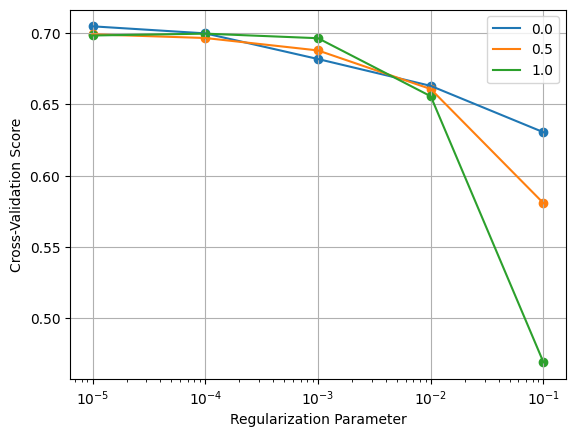

In [0]:
# Plotting the cross-validation results
model_params = logreg_model.getEstimatorParamMaps()
lr_cv_summary_list = []
for param_set, acc in zip(model_params, logreg_model.avgMetrics):
    new_set = list(param_set.values()) + [acc] 
    lr_cv_summary_list.append(new_set)

cv_summary = pd.DataFrame(lr_cv_summary_list,
                          columns=['reg_param', 'enet_param', 'acc'])
for en in cv_summary.enet_param.unique():
    sel = cv_summary.enet_param == en 
    plt.plot(cv_summary.reg_param[sel], cv_summary.acc[sel], label=en) 
    plt.scatter(cv_summary.reg_param[sel], cv_summary.acc[sel])
plt.legend()
plt.xscale('log')
plt.grid()
plt.xlabel('Regularization Parameter') 
plt.ylabel('Cross-Validation Score') 
plt.show()

## Part E: Hyperparameter Tuning for Decision Trees

Performing grid search and cross-validation hyperparameter tuning for decision trees.

In [0]:
# Creating Decision Tree Classifier
dt = DecisionTreeClassifier(labelCol='Cover_Type', featuresCol='features_dt', maxBins=38, seed=1)

# # Grid search for the optimal hyperparameters
dt_param_grid = (
        ParamGridBuilder()
        .addGrid(dt.maxDepth, [4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24])
        .addGrid(dt.minInstancesPerNode, [1, 2, 4])
        ).build()

# Creating a cross-validator
dt_crossval = CrossValidator(estimator=dt, estimatorParamMaps=dt_param_grid, evaluator=accuracy_eval, numFolds=5)

# Fitting the cross-validator on the training data
cv_model = dt_crossval.fit(train)


Identifying the optimal model found by the grid search algorithm.

In [0]:
# Optimal model
dt_model = cv_model.bestModel

# Identifying maxDepth and minInstancesPerNode
dt_maxDepth = dt_model.getMaxDepth()
dt_minInstancesPerNode = dt_model.getMinInstancesPerNode()
dt_score =max(cv_model.avgMetrics)
 

# Printing the optimal model
print(" Max CV Score:    ", dt_score)
print(" Optimal Depth:   ", dt_maxDepth)
print(" Optimal MinInst: ", dt_minInstancesPerNode)


 Max CV Score:     0.7768887432924985
 Optimal Depth:    16
 Optimal MinInst:  1


Visualizing Cross-Validation results

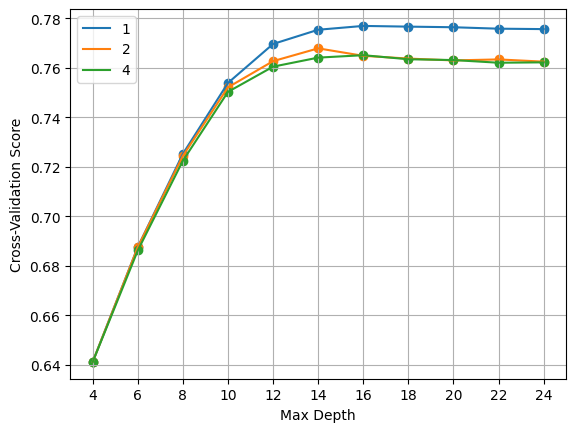

In [0]:
# Plotting the cross-validation results
model_params = cv_model.getEstimatorParamMaps()

dt_cv_summary_list = []
for param_set, acc in zip(model_params, cv_model.avgMetrics):
    new_set = list(param_set.values()) + [acc] 
    dt_cv_summary_list.append(new_set)
cv_summary = pd.DataFrame(dt_cv_summary_list, 
                          columns=['maxDepth', 'minInst', 'acc'])
for mi in cv_summary.minInst.unique():
    sel = cv_summary.minInst == mi 
    plt.plot(cv_summary.maxDepth[sel], cv_summary.acc[sel], label=mi) 
    plt.scatter(cv_summary.maxDepth[sel], cv_summary.acc[sel])
plt.legend()
plt.grid()
plt.xticks(range(4,26,2)) 
plt.xlabel('Max Depth') 
plt.ylabel('Cross-Validation Score') 
plt.show()

Displaying features and feature importance

In [0]:
# Features and feature importances
features = num_features + ix_features
pd.DataFrame(list(zip(fc_proc.columns, dt_model.featureImportances)), 
             columns=['feature', 'importance']).sort_values('importance', ascending=False)

,feature,importance
0,Elevation,0.425148
5,Horizontal_Distance_To_Roadways,0.082644
3,Horizontal_Distance_To_Hydrology,0.072353
9,Horizontal_Distance_To_Fire_Points,0.067539
6,Hillshade_9am,0.051475
1,Aspect,0.050639
2,Slope,0.038455
4,Vertical_Distance_To_Hydrology,0.027053
7,Hillshade_Noon,0.020240
8,Hillshade_3pm,0.020077


## Part F: Identifying and Evaluating the Final Model

The Decision Tree Model has a higher cross-validation (CV) score of 0.7769, compared to the Logistic Regression Model, which achieved a CV score of 0.7048. The cross-validation score indicates how well a model is expected to perform on unseen, out-of-sample data, and a higher score suggests better generalization to new data. The difference in scores (0.7769 vs. 0.7048) suggests that the Decision Tree is likely capturing more of the underlying patterns in the data, thus leading to better performance on unseen data. The Decision Tree's optimal depth of 16 allows it to model more complex relationships, while Logistic Regression, being a linear model, might struggle with capturing non-linear patterns, especially if the data exhibits such relationships.

Generating predictions with test data

In [0]:

# Transforming the test data
test_pred = dt_model.transform(test)

# Evaluating the model
test_pred.select('probability', 'prediction', 'Cover_Type').show(10, truncate=False)

+------------------------------------------------------------------------------+----------+----------+
|probability                                                                   |prediction|Cover_Type|
+------------------------------------------------------------------------------+----------+----------+
|[0.0,0.0,0.0,0.15384615384615385,0.0,0.0,0.8461538461538461,0.0]              |6.0       |6         |
|[0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0]                                             |6.0       |6         |
|[0.0,0.0,0.0,0.8888888888888888,0.0,0.0,0.1111111111111111,0.0]               |3.0       |6         |
|[0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0]                                             |3.0       |3         |
|[0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0]                                             |3.0       |6         |
|[0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0]                                             |3.0       |3         |
|[0.0,0.0,0.0,0.3333333333333333,0.1111111111111111,0.0,0.555555555555555

Calculating Accuracy of the dt_model on test

In [0]:
from pyspark.mllib.evaluation import MulticlassMetrics
pred_and_labels = test_pred.rdd.map(lambda x:(x['prediction'],float(x['Cover_Type'])))

# Create MulticlassMetrics object
metrics = MulticlassMetrics(pred_and_labels)

# Print Accuracy
print('Test Set Accuracy = ', round(metrics.accuracy, 4))


/databricks/spark/python/pyspark/sql/context.py:165: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Test Set Accuracy =  0.7848


Creating Confusuin matrix

In [0]:
# Extract confusion matrix
confusion_matrix = metrics.confusionMatrix().toArray()
conf_matrix_df = pd.DataFrame(confusion_matrix, index=range(1,8), columns=range(1,8))

# Print confusion matrix
print(conf_matrix_df)



       1      2      3      4      5      6      7
1  293.0  103.0    1.0    0.0   14.0    2.0   44.0
2  103.0  216.0   10.0    0.0   62.0    9.0    5.0
3    0.0    4.0  330.0   21.0    9.0   67.0    0.0
4    0.0    1.0   16.0  434.0    0.0   20.0    0.0
5    9.0   18.0    5.0    0.0  372.0    2.0    0.0
6    0.0    2.0   64.0   12.0    6.0  316.0    0.0
7   31.0    4.0    0.0    0.0    2.0    0.0  395.0


Observations in the test set with Cover Type 1 were misclassified by the model as Cover Type 2 a total of 103 times. This was the most common type of misclassification in the test set.


Getting deeper understanding of the model performance with precision and recall

In [0]:
# Display metrics
print("Label   Precision   Recall")
print("--------------------------")
for label in range(1, 8):
    print(f"{label}      {round(metrics.precision(label), 4)}      {round(metrics.recall(label), 4)}")

Label   Precision   Recall
--------------------------
1      0.672      0.6411
2      0.6207      0.5333
3      0.7746      0.7657
4      0.9293      0.9214
5      0.8      0.9163
6      0.7596      0.79
7      0.8896      0.9144


- The cover type most likely to be correctly classified by our final model is Cover Type 4, which has the highest precision (0.9293) and recall (0.9214). High precision indicates that when the model predicts Cover Type 4, it is correct 92.93% of the time. High recall suggests that the model correctly identifies 92.14% of the actual instances of Cover Type 4.

- The cover type most likely to be misclassified by our final model is Cover Type 2, which has the lowest recall (0.5333) among all cover types. A recall of 53.33% indicates that only about half of the actual instances of Cover Type 2 are correctly identified by the model. This suggests that there may be significant confusion between Cover Type 2 and other cover types, leading to a higher chance of misclassification.

- Cover Type 5 has the greatest difference between its precision (0.8) and recall (0.9163). This means that when the model predicts Cover Type 5, it is correct 80% of the time. This indicates that the model is able to identify 91.63% of the actual Cover Type 5 instances.